- create model based on past observations ($\theta X_{t-1}$) and past innovations ($a_{t}$)
  (difference between last and current observation)

- I in ARIMA: integrated
- integrated: extract noise from non-stationary time series and apply ARMA model to it

# 1. MODEL IDENTIFICATION

In [1]:
### Load time series packages
library(tseries)
library(TSA)
library(forecast)

Loading required package: leaps
Loading required package: locfit
locfit 1.5-9.1 	 2013-03-22
Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-12. For overview type 'help("mgcv-package")'.

Attaching package: ‘TSA’

The following objects are masked from ‘package:stats’:

    acf, arima

The following object is masked from ‘package:utils’:

    tar

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate

Attaching package: ‘timeDate’

The following objects are masked from ‘package:TSA’:

    kurtosis, skewness

This is forecast 7.1 


Attaching package: ‘forecast’

The following objects are masked from ‘package:TSA’:

    fitted.Arima, plot.Arima

The following object is masked from ‘package:nlme’:

    getResponse



## 1.1. Homogenize variances

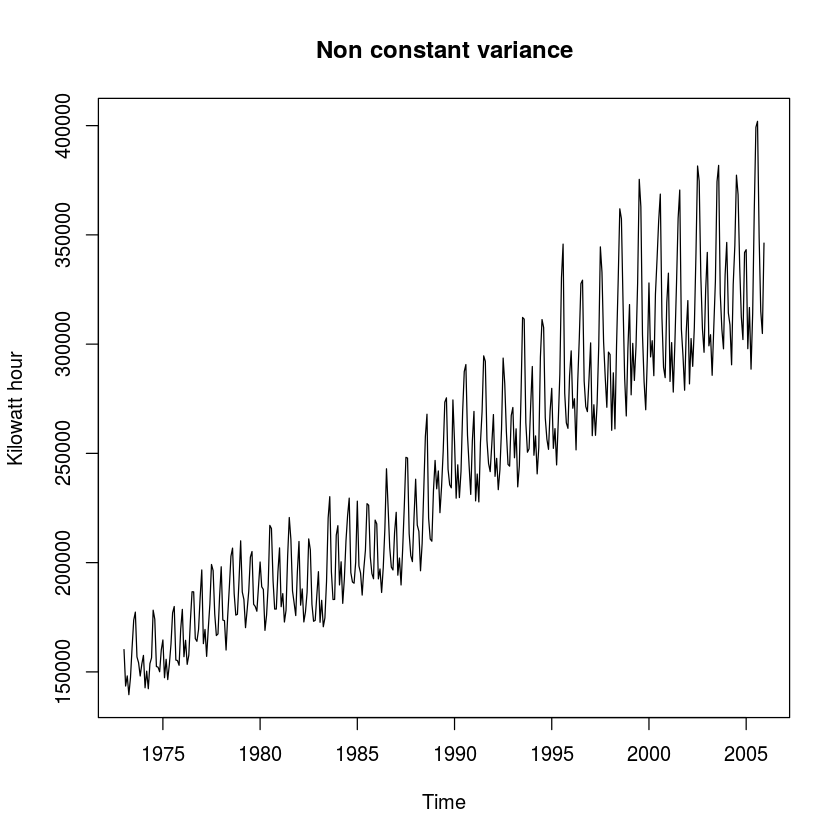

In [24]:
# par(mfcol=c(2,1)) # plot parameter: print two plots above each other
data(electricity) # time series
plot(electricity, ylab="Kilowatt hour")
title(main="Non constant variance")

Keep variance constant by log transformation:

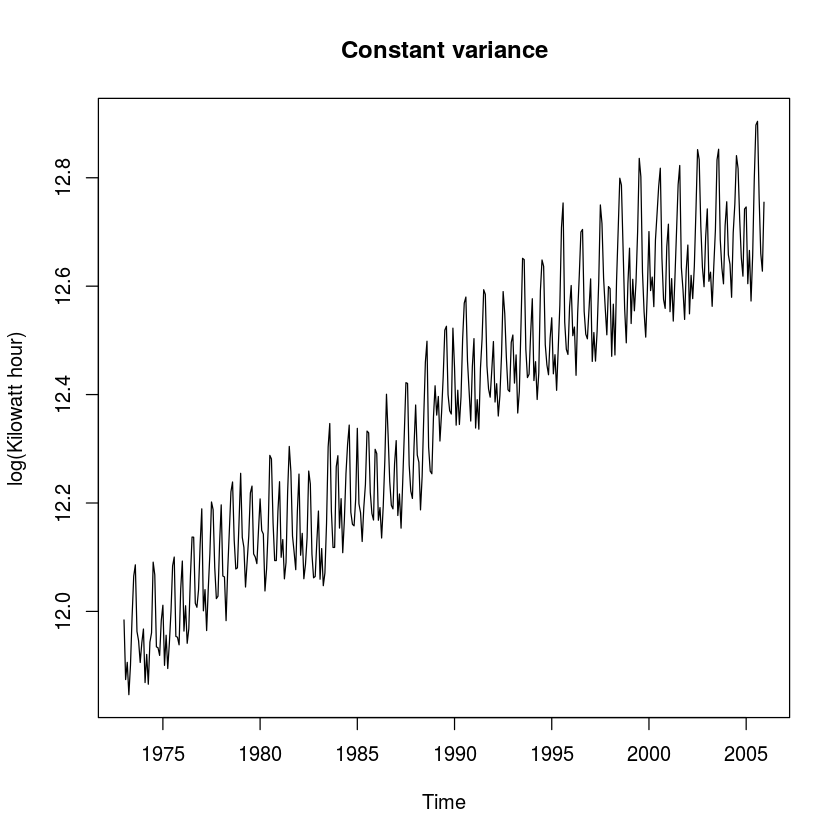

In [25]:
plot(log(electricity), ylab="log(Kilowatt hour)")
title(main="Constant variance")

## 1.2. Regular and seasonal differences of the time series

There are two different `co2` time series, so we'll have to specify which one
we want to load / work with:

In [26]:
data(co2, package="TSA")

The function `diff` can be used to differenciate (e.g. detrend) the data.

- lag=1: always substract the last data point
  - gets rid of the trend component
  
- lag=12: always substract the n-12th data point
  - gets rid of the seasonal component (in case of monthly data)
  
- apply both lags to get the remainder

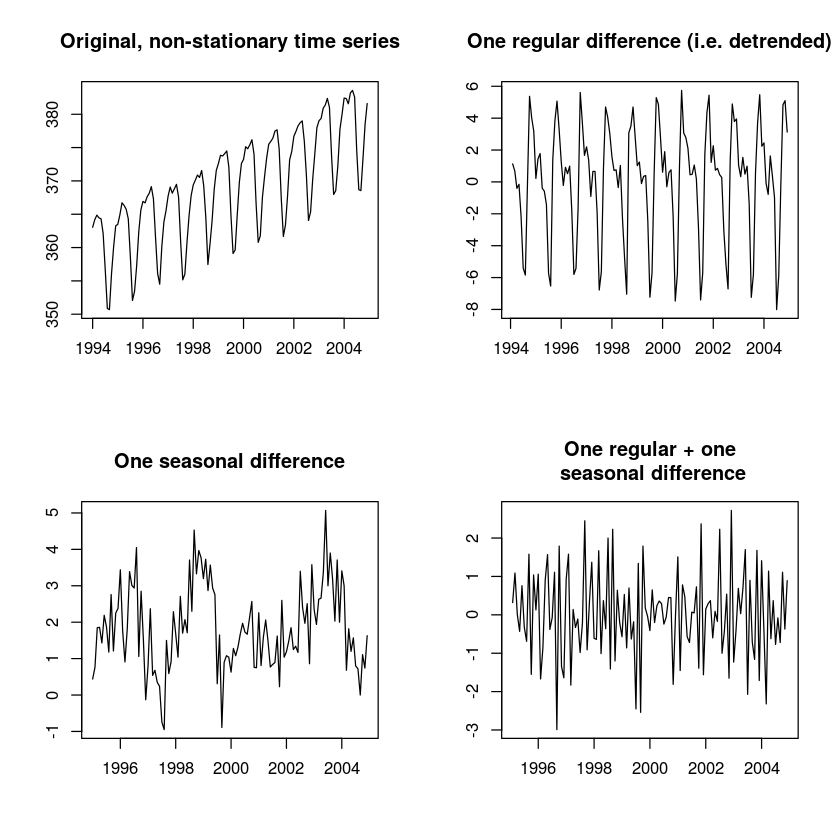

In [30]:
## Time series plot
par(mfcol=c(2,2)) # plot 4 graphs in a 2x2 matrix

plot(co2, ylab="", xlab="")
title(main="Original, non-stationary time series")

plot(diff(co2, lag=12), ylab="", xlab="")
title(main="One seasonal difference")

plot(diff(co2, lag=1), ylab="", xlab="")
title(main="One regular difference (i.e. detrended)")

plot(diff(diff(co2, lag=1), lag=12), ylab="", xlab="")
title(main="One regular + one\n seasonal difference")

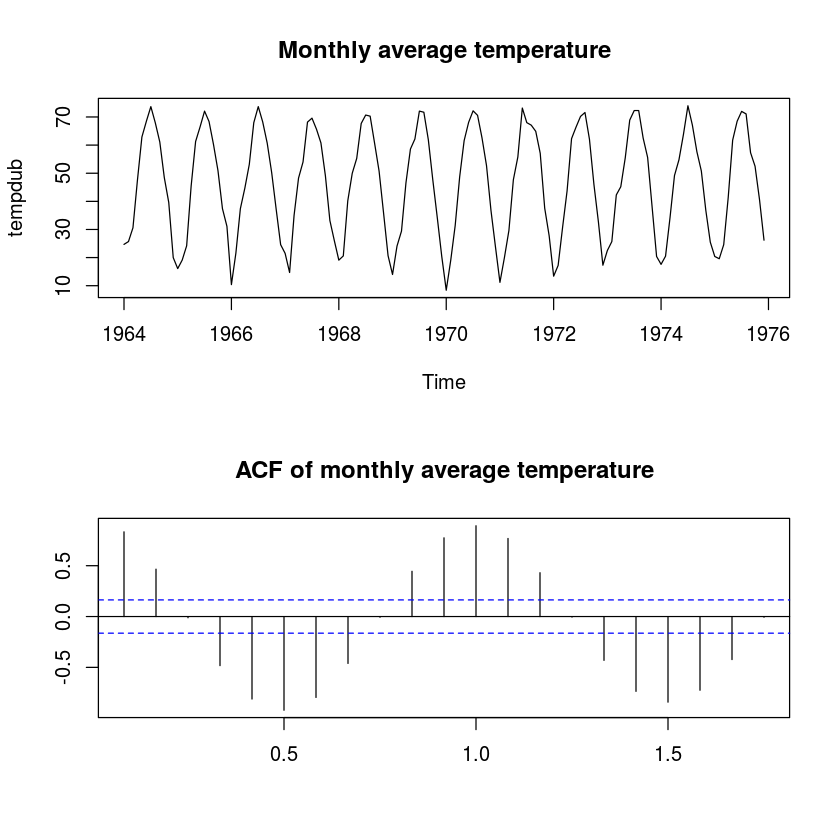

In [36]:
### The autocorrelogram function (ACF)
data(tempdub)

par(mfcol=c(2,1))
plot(tempdub, main="Monthly average temperature")
acf(tempdub, ylab="", xlab="", main="ACF of monthly average temperature")

The ACF plot clearly shows that temperature is possitively correlated with 12 months ago (0.0, 1.0)
temperature is negatively correlated with 6 months ago (0.5, 1.5)


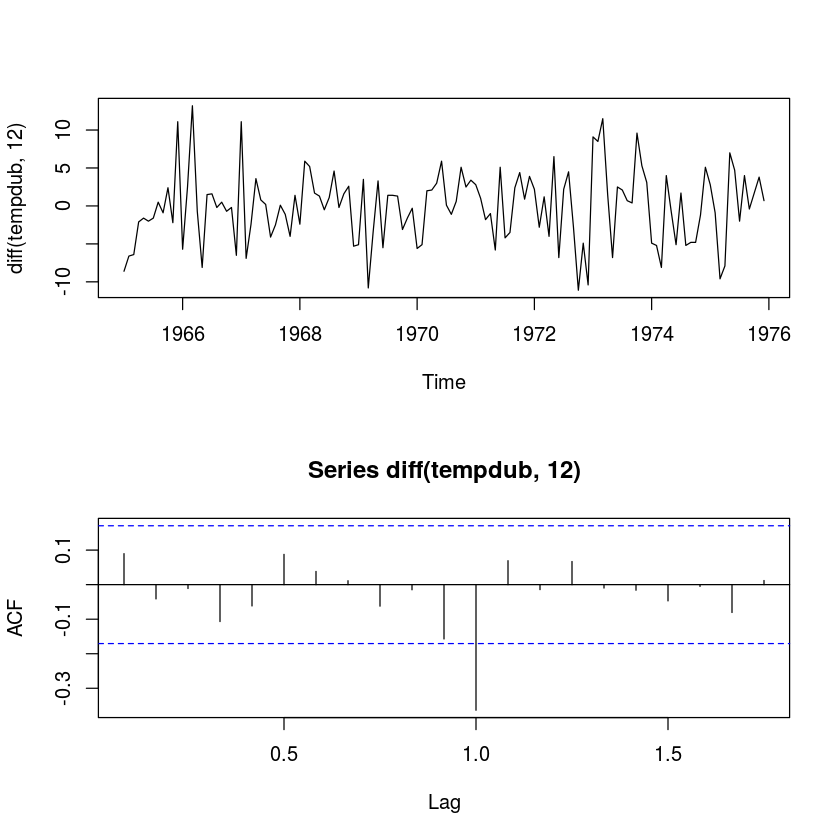

In [37]:
par(mfcol=c(2,1))
plot(diff(tempdub, 12))
acf(diff(tempdub, 12))

Without seasonality, the ACF ownly shows one negative correlation with
the same month one year ago. (This has to do with the stationary part...)

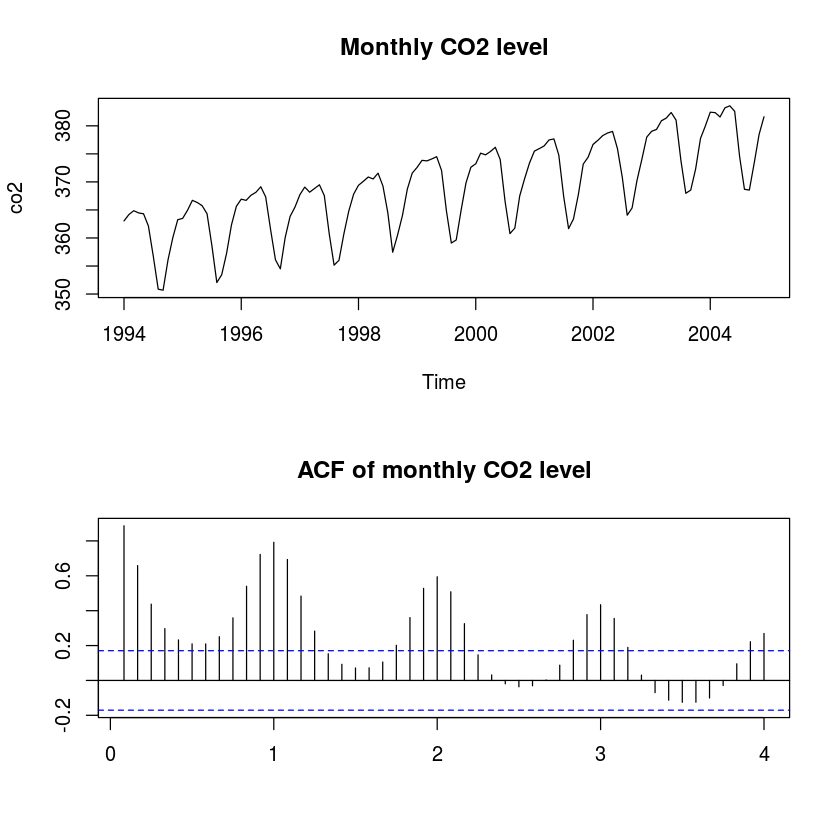

In [35]:
par(mfcol=c(2,1))
plot(co2, main="Monthly CO2 level")
acf(co2, lag.max=48, ylab="", xlab="", main="ACF of monthly CO2 level")

## 1.3. Identify AR (p, P) and MA (q, Q) polynomials for the regular and seasonal structure of a time series

We will look at AR(1), MA(1), AR(2), MA(2) and ARMA(1,1).

We will use simulated, stationary data.

MA(2) means that the model only depends on last two innovations.

This is the most challenging part.

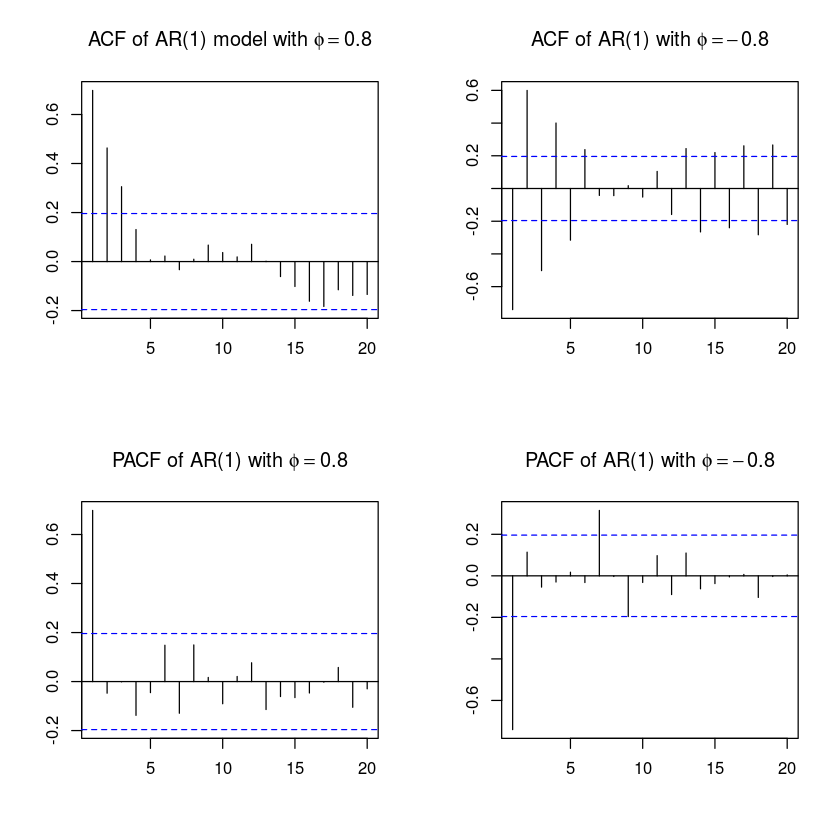

In [5]:
### ACF and PACF of an AR(1) model
par(mfcol=c(2,2))

# create 100 random data points in an AR model with coefficient phi 0.8 and -0.8
ar1.pos <- arima.sim(n= 100, model=list(ar=c(0.8)))
ar1.neg <- arima.sim(n= 100, model=list(ar=c(-0.8)))
title <- expression(paste("ACF of AR(1) model with ", phi == 0.8))
# exponential decrease
acf(ar1.pos, xlab="", ylab="", main=title)

title <- expression(paste("PACF of AR(1) with ", phi == 0.8))
pacf(ar1.pos, xlab="", ylab="", main=title)

title <- expression(paste("ACF of AR(1) with ", phi == -0.8))
acf(ar1.neg, xlab="", ylab="", main=title)

# exponential decrease with alternating signs
title <- expression(paste("PACF of AR(1) with ", phi == -0.8))
pacf(ar1.neg, xlab="", ylab="", main=title)

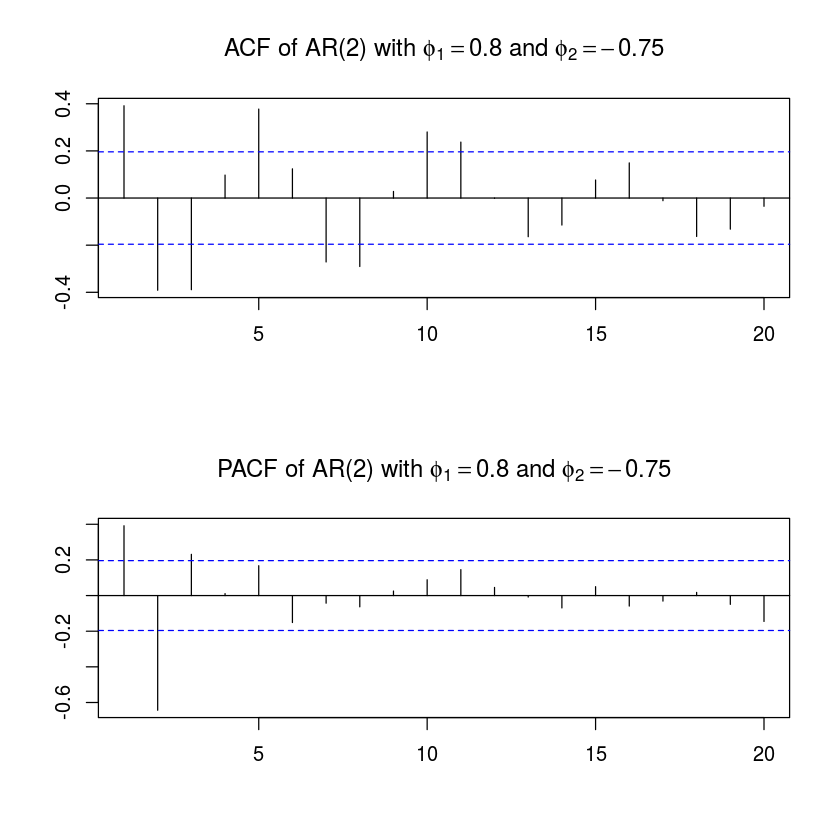

In [6]:
### ACF and PACF of an AR(2) model
par(mfcol=c(2,1))
ar2 <- arima.sim(n= 100, model=list(ar=c(0.8, -0.75)))
tit <- expression(paste("ACF of AR(2) with ", phi[1] == 0.8, " and ", phi[2] == -0.75))

# exponential decrease in ACF values with alternating signs
acf(ar2, xlab="", ylab="", main=tit)


tit <- expression(paste("PACF of AR(2) with ", phi[1] == 0.8, " and ", phi[2] == -0.75))
# the two first lags are significant, the rest is not
pacf(ar2, xlab="", ylab="", main=tit)

In a MA model, we should see the opposite pattern:

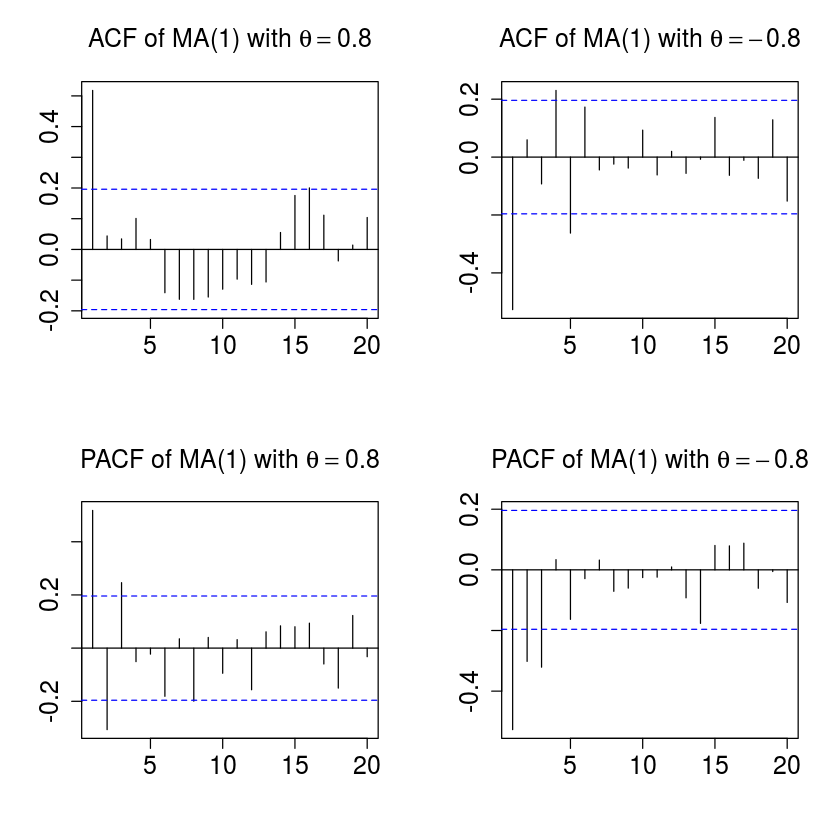

In [7]:
### ACF and PACF of an MA(1) model
par(mfcol=c(2,2), cex.axis=1.5, cex.main=1.5)
ma1.pos <- arima.sim(n= 100, model=list(ma=c(0.8)))
ma1.neg <- arima.sim(n= 100, model=list(ma=c(-0.8)))
tit <- expression(paste("ACF of MA(1) with ", theta == 0.8))
acf(ma1.pos, xlab="", ylab="", main=tit)
tit <- expression(paste("PACF of MA(1) with ", theta == 0.8))
pacf(ma1.pos, xlab="", ylab="", main=tit)
tit <- expression(paste("ACF of MA(1) with ", theta == -0.8))
acf(ma1.neg, xlab="", ylab="", main=tit)
tit <- expression(paste("PACF of MA(1) with ", theta == -0.8))
pacf(ma1.neg, xlab="", ylab="", main=tit)

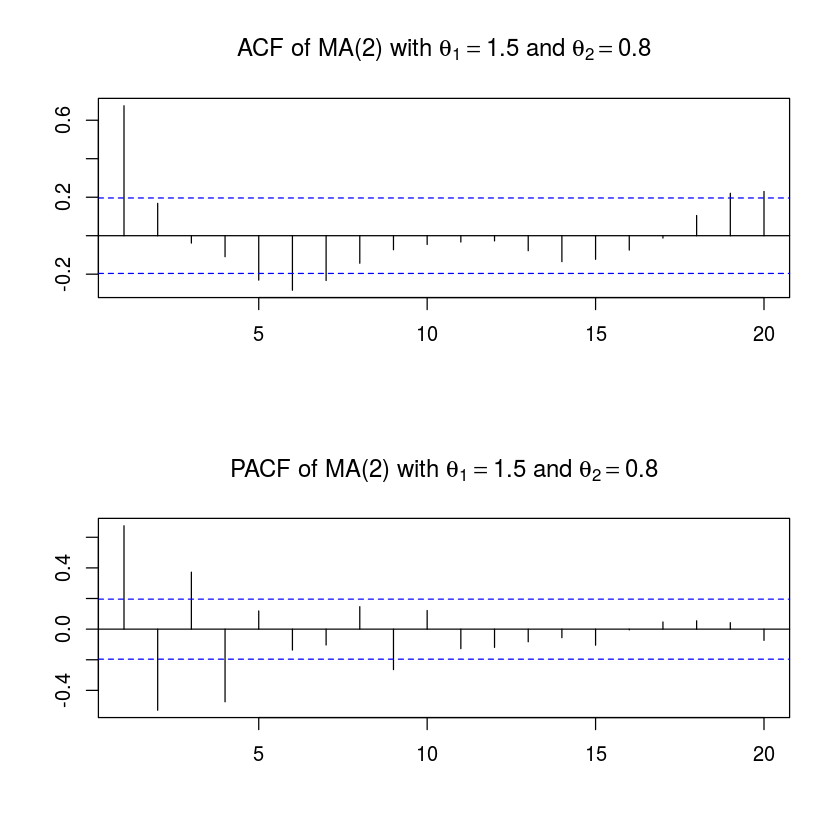

In [8]:
### ACF and PACF of an MA(2) model
par(mfcol=c(2,1))
ma2 <- arima.sim(n= 100, model=list(ma=c(1.5,0.8)))
tit <- expression(paste("ACF of MA(2) with ", theta[1] == 1.5, " and ", theta[2] == 0.8))
# should be an exponential decrease
acf(ma2, xlab="", ylab="", main=tit)
tit <- expression(paste("PACF of MA(2) with ", theta[1] == 1.5, " and ", theta[2] == 0.8))
# the first three lags are significant (it should be only the first two,
# since this is a MA model of order 2
pacf(ma2, xlab="", ylab="", main=tit)

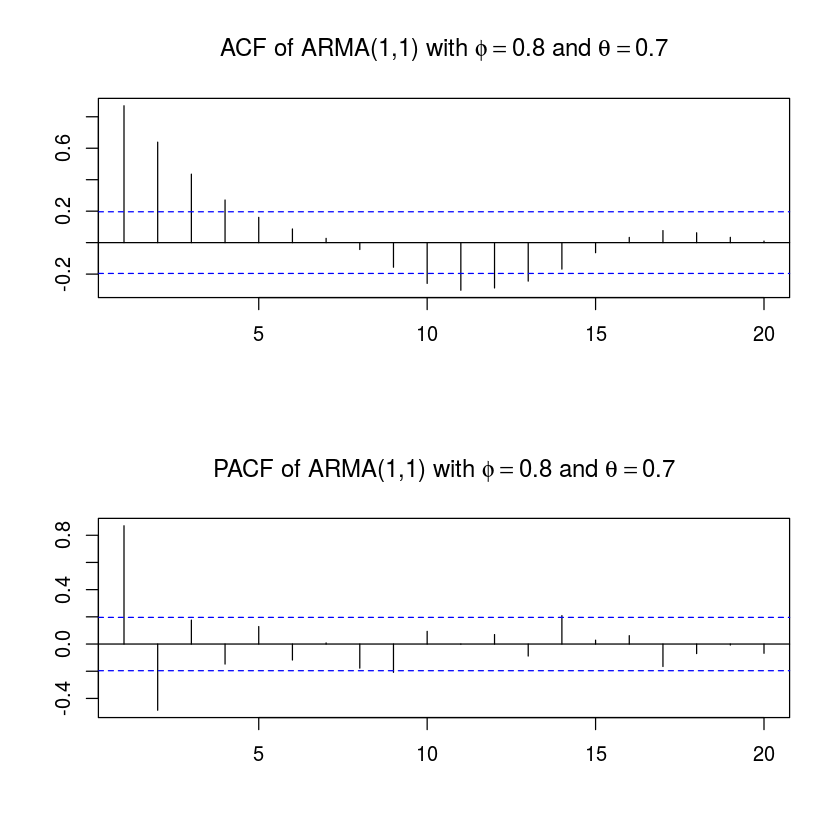

In [9]:
### ACF and PACF of an ARMA(1,1) model

# We expect exponential decrease in ACF and a significant first lag in PACF.

par(mfcol=c(2,1))
arma1.1 <- arima.sim(n= 100, model=list(ar=0.8, ma=0.7))
tit <- expression(paste("ACF of ARMA(1,1) with ", phi == 0.8, " and ", theta == 0.7))
acf(arma1.1, xlab="", ylab="", main=tit)
tit <- expression(paste("PACF of ARMA(1,1) with ", phi == 0.8, " and ", theta == 0.7))
pacf(arma1.1, xlab="", ylab="", main=tit)

## ACF and PACF of a seasonal ARMA model

We want to identify the polynomials.
Let's use real data.
First, we'll have to make it stationary.

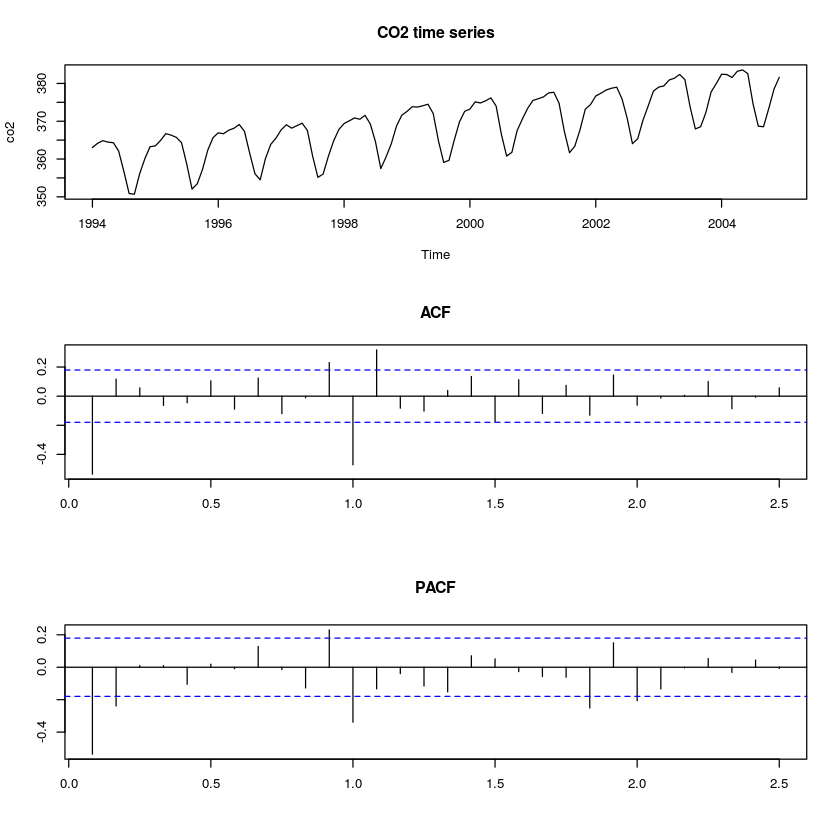

In [10]:
par(mfcol=c(3,1))
plot(co2, main="CO2 time series")
co2.stat <- diff(diff(co2, lag=1), lag=12) # detrend / deseasonalize

# no exponential decrease -> no AR
# lag 1.0 is significant -> MA(1, 1) 
acf(co2.stat, xlab="", ylab="", main="ACF", lag.max=30)

# exponential decrease
pacf(co2.stat, xlab="", ylab="", main="PACF", lag.max=30)

# 2. PARAMETER ESTIMATION

## Model fitting

In [11]:
# regular: c(p=AR,d=I, q=MA)
# seasonal: c(P=AR,D=I, Q=MA)

# here: MA(regular 1, seasonal 1)

arima.co2 <- arima(co2, order=c(0,1,1), seasonal=list(order=c(0,1,1)))
arima.co2


Call:
arima(x = co2, order = c(0, 1, 1), seasonal = list(order = c(0, 1, 1)))

Coefficients:
          ma1     sma1
      -0.5792  -0.8206
s.e.   0.0791   0.1137

sigma^2 estimated as 0.5446:  log likelihood = -139.54,  aic = 283.08

## Automatic selection of polynomials for the regular and seasonal components of the ARMA model

This is a shortcut to #1.3.

In [12]:
best.arima<-auto.arima(co2, d=1, D=1, max.p=5, max.q=5, max.P=2, max.Q=2)
best.arima

Series: co2 
ARIMA(0,1,1)(0,1,1)[12]                    

Coefficients:
          ma1     sma1
      -0.5792  -0.8206
s.e.   0.0791   0.1137

sigma^2 estimated as 0.5683:  log likelihood=-139.54
AIC=285.08   AICc=285.29   BIC=293.41

# 3. MODEL VALIDATION

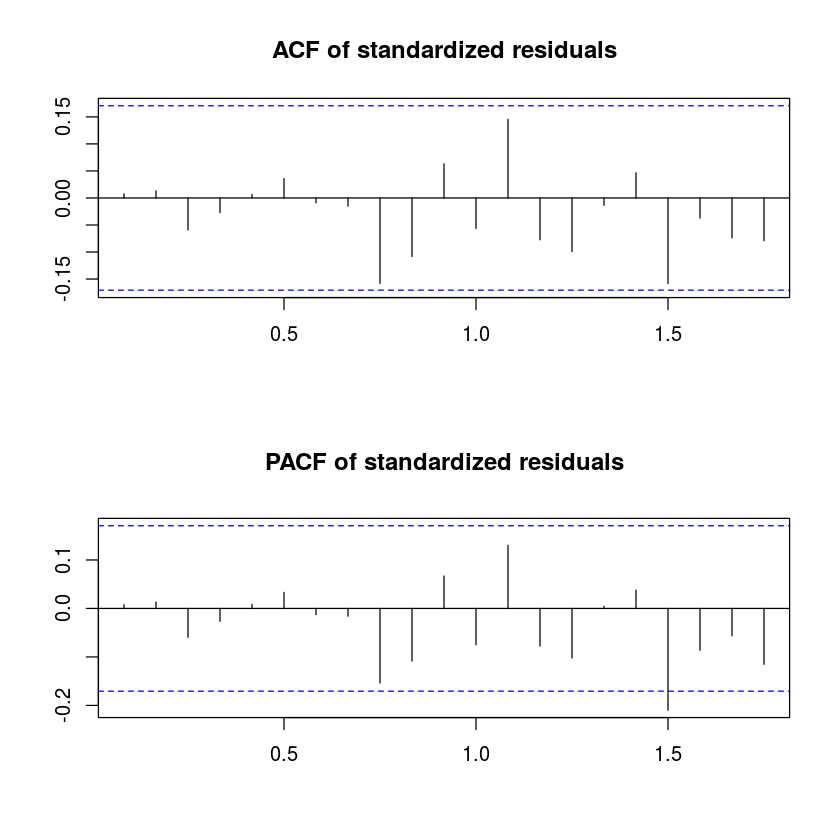

In [13]:
### ACF and PACF of the standardized residuals
par(mfcol=c(2,1))

# We should not see any pattern in the residuals.

acf(rstandard(arima.co2), xlab="", ylab="", main="ACF of standardized residuals")
pacf(rstandard(arima.co2), xlab="", ylab="", main="PACF of standardized residuals")

In [14]:
### Ljung-Box-Pierce test
Box.test(rstandard(arima.co2), lag=12, type="Ljung-Box")
LB.test(arima.co2, lag=12)


	Box-Ljung test

data:  rstandard(arima.co2)
X-squared = 7.1761, df = 12, p-value = 0.8458



	Box-Ljung test

data:  residuals from  arima.co2
X-squared = 7.051, df = 10, p-value = 0.7206


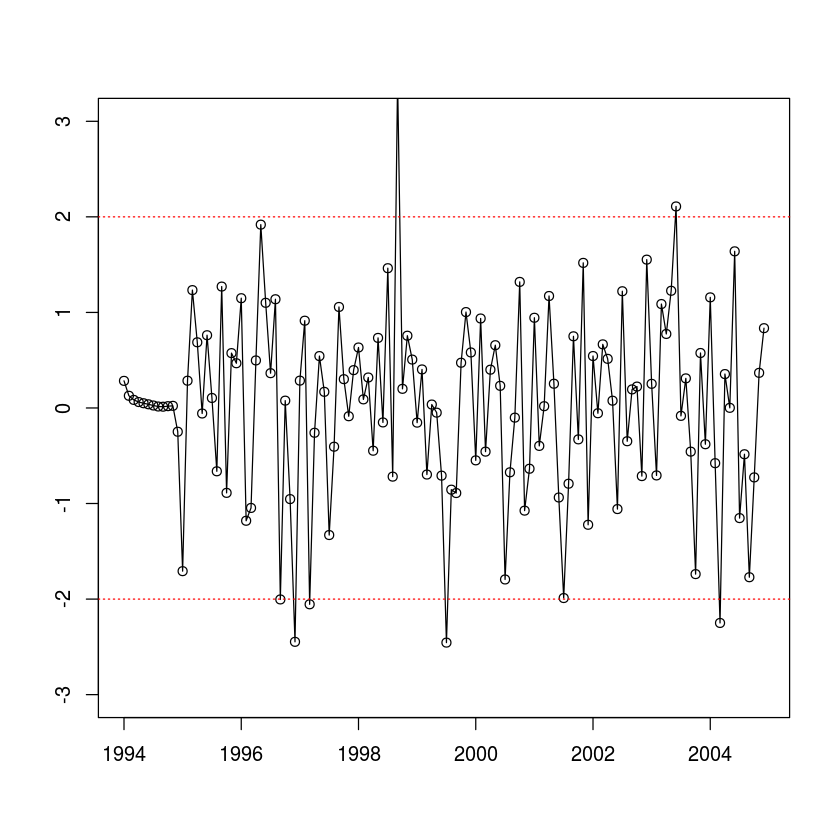

In [15]:
### Plot of standardized residuals

# most residuals are within the SD, so the residuals are normaly distributed
plot(rstandard(arima.co2), xlab="", ylab="", main="", type="o", ylim=c(-3,3))
abline(h=2, lty=3, col="red")
abline(h=-2, lty=3, col="red")

# 4. FORECASTING

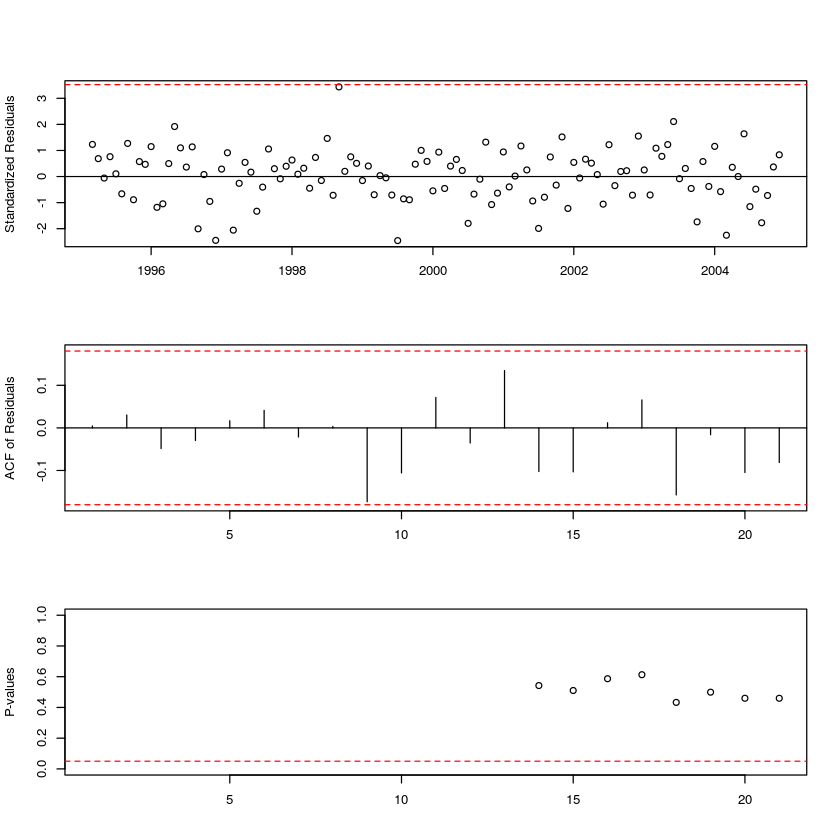

In [44]:
# diagnose the model (like we did before, but in one step)
tsdiag(arima.co2)

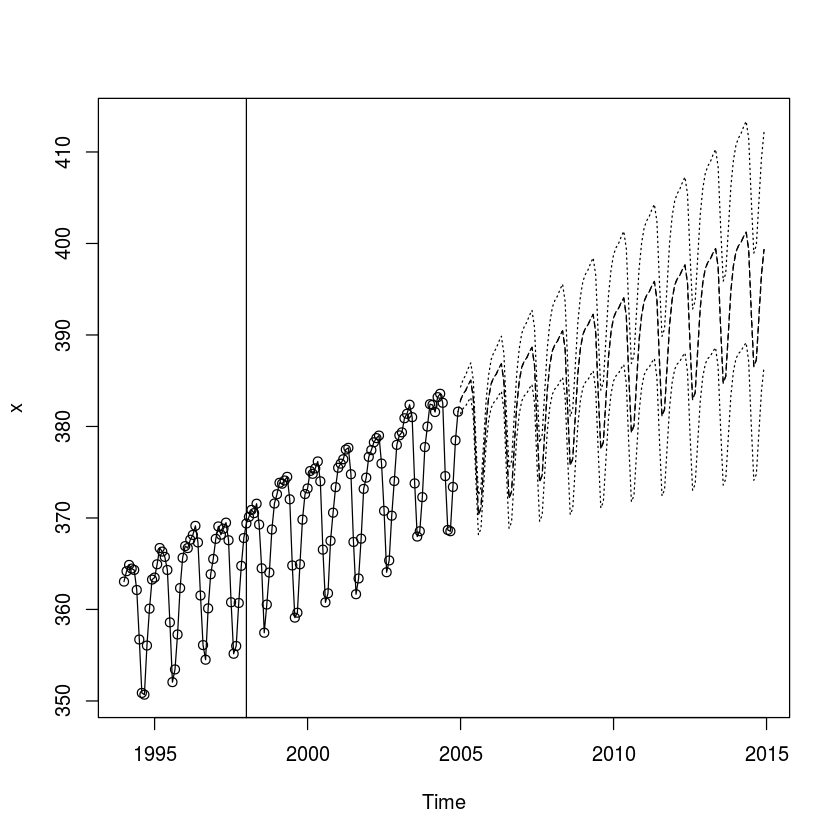

In [45]:
# there's another function called plot.Arima, so we'll have to use the namespace
TSA::plot.Arima(arima.co2, n.ahead=120, type='l')
abline(v=1998)